<a href="https://colab.research.google.com/github/Balajinanda/Large-Language-Models/blob/main/Text_Classification_of_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing libraries**

In [1]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requi

In [2]:
# Required libraries
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from transformers import BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader

# **Loading the dataset**

In [3]:
# Load the TREC-6 dataset
dataset = load_dataset('trec')

# Inspect the dataset structure
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for trec contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/trec.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/5452 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 5452
    })
    test: Dataset({
        features: ['text', 'coarse_label', 'fine_label'],
        num_rows: 500
    })
})


# **Data Overview**

In [35]:
print(dataset['train'].features)

{'text': Value(dtype='string', id=None), 'coarse_label': ClassLabel(names=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'], id=None), 'fine_label': ClassLabel(names=['ABBR:abb', 'ABBR:exp', 'ENTY:animal', 'ENTY:body', 'ENTY:color', 'ENTY:cremat', 'ENTY:currency', 'ENTY:dismed', 'ENTY:event', 'ENTY:food', 'ENTY:instru', 'ENTY:lang', 'ENTY:letter', 'ENTY:other', 'ENTY:plant', 'ENTY:product', 'ENTY:religion', 'ENTY:sport', 'ENTY:substance', 'ENTY:symbol', 'ENTY:techmeth', 'ENTY:termeq', 'ENTY:veh', 'ENTY:word', 'DESC:def', 'DESC:desc', 'DESC:manner', 'DESC:reason', 'HUM:gr', 'HUM:ind', 'HUM:title', 'HUM:desc', 'LOC:city', 'LOC:country', 'LOC:mount', 'LOC:other', 'LOC:state', 'NUM:code', 'NUM:count', 'NUM:date', 'NUM:dist', 'NUM:money', 'NUM:ord', 'NUM:other', 'NUM:period', 'NUM:perc', 'NUM:speed', 'NUM:temp', 'NUM:volsize', 'NUM:weight'], id=None)}


In [36]:
print(dataset['test'].features)

{'text': Value(dtype='string', id=None), 'coarse_label': ClassLabel(names=['ABBR', 'ENTY', 'DESC', 'HUM', 'LOC', 'NUM'], id=None), 'fine_label': ClassLabel(names=['ABBR:abb', 'ABBR:exp', 'ENTY:animal', 'ENTY:body', 'ENTY:color', 'ENTY:cremat', 'ENTY:currency', 'ENTY:dismed', 'ENTY:event', 'ENTY:food', 'ENTY:instru', 'ENTY:lang', 'ENTY:letter', 'ENTY:other', 'ENTY:plant', 'ENTY:product', 'ENTY:religion', 'ENTY:sport', 'ENTY:substance', 'ENTY:symbol', 'ENTY:techmeth', 'ENTY:termeq', 'ENTY:veh', 'ENTY:word', 'DESC:def', 'DESC:desc', 'DESC:manner', 'DESC:reason', 'HUM:gr', 'HUM:ind', 'HUM:title', 'HUM:desc', 'LOC:city', 'LOC:country', 'LOC:mount', 'LOC:other', 'LOC:state', 'NUM:code', 'NUM:count', 'NUM:date', 'NUM:dist', 'NUM:money', 'NUM:ord', 'NUM:other', 'NUM:period', 'NUM:perc', 'NUM:speed', 'NUM:temp', 'NUM:volsize', 'NUM:weight'], id=None)}


In [37]:
# Convert dataset to pandas DataFrame
train_trec = pd.DataFrame(dataset['train'])
test_trec = pd.DataFrame(dataset['test'])

# Check the first few rows of the DataFrame to understand the structure
print(train_trec.head())
print(test_trec.head())

                                                text  coarse_label  fine_label
0  How did serfdom develop in and then leave Russ...             2          26
1   What films featured the character Popeye Doyle ?             1           5
2  How can I find a list of celebrities ' real na...             2          26
3  What fowl grabs the spotlight after the Chines...             1           2
4                    What is the full form of .com ?             0           1
                                       text  coarse_label  fine_label
0      How far is it from Denver to Aspen ?             5          40
1  What county is Modesto , California in ?             4          32
2                         Who was Galileo ?             3          31
3                         What is an atom ?             2          24
4          When did Hawaii become a state ?             5          39


# **EDA Analysis**

In [38]:
# Calculate the frequency of each coarse label for training and test sets
train_label_frequencies = train_trec['coarse_label'].value_counts()
test_label_frequencies = test_trec['coarse_label'].value_counts()

# Get label names from the dataset
label_names = dataset['train'].features['coarse_label'].int2str

In [39]:
# Create a DataFrame for plotting
train_label_data = pd.DataFrame({
    'Label': train_label_frequencies.index.map(label_names),
    'Count': train_label_frequencies.values
})

# Plot the distribution of coarse labels in the training dataset
train_fig = px.bar(
    train_label_data,
    x='Label',
    y='Count',
    title='Coarse Label Distribution in Training Set',
    labels={'Count': 'Frequency', 'Label': 'Coarse Label'}
)
train_fig.update_layout(xaxis={'categoryorder': 'total descending'})

# Show the figure
train_fig.show()

In [40]:
# Create a DataFrame for plotting
test_label_data = pd.DataFrame({
    'Label': test_label_frequencies.index.map(label_names),
    'Count': test_label_frequencies.values
})

# Plot the distribution of coarse labels in the test dataset
test_fig = px.bar(
    test_label_data,
    x='Label',
    y='Count',
    title='Coarse Label Distribution in Test Set',
    labels={'Count': 'Frequency', 'Label': 'Coarse Label'}
)
test_fig.update_layout(xaxis={'categoryorder': 'total descending'})

# Show the figure
test_fig.show()

In [41]:
# Calculate the length of each text entry
train_trec['text_length'] = train_trec['text'].apply(lambda x: len(x.split()))
test_trec['text_length'] = test_trec['text'].apply(lambda x: len(x.split()))

# Get label names from the dataset
label_names = dataset['train'].features['coarse_label'].int2str

# Map label IDs to label names
train_trec['Label'] = train_trec['coarse_label'].map(label_names)
test_trec['Label'] = test_trec['coarse_label'].map(label_names)

In [42]:
# Create box plots for the training dataset
train_fig = px.box(
    train_df,
    x='Label',
    y='text_length',
    title='Text Length Distribution by Coarse Label in Training Set',
    labels={'text_length': 'Text Length (Number of Tokens)', 'Label': 'Coarse Label'}
)
train_fig.update_layout(xaxis={'categoryorder': 'total ascending'})
train_fig.show()

In [43]:
# Create box plots for the test dataset
test_fig = px.box(
    test_df,
    x='Label',
    y='text_length',
    title='Text Length Distribution by Coarse Label in Test Set',
    labels={'text_length': 'Text Length (Number of Tokens)', 'Label': 'Coarse Label'}
)
test_fig.update_layout(xaxis={'categoryorder': 'total ascending'})
test_fig.show()

# **Tokenization of dataset**

In [44]:
# Load the tokenizer
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [45]:
# Define a tokenization function
def tokenize_function(example, tokenizer, padding='max_length', truncation=True, max_length=128):
    """
    Tokenizes the input text using the specified tokenizer.

    Parameters:
    - example: A dictionary containing the text to be tokenized.
    - tokenizer: The tokenizer to be used for tokenization.
    - padding: Type of padding to apply ('max_length', 'longest', or None).
    - truncation: Whether to truncate sequences to fit within the max_length.
    - max_length: The maximum length of sequences after padding/truncation.

    Returns:
    - A dictionary containing the tokenized input_ids, attention_mask, and token_type_ids.
    """
    return tokenizer(
        example['text'],
        padding=padding,
        truncation=truncation,
        max_length=max_length
    )

In [51]:
# Apply the tokenization function to your dataset
tokenized_datasets = dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

# Remove the original text column
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

# Rename the labels column
tokenized_datasets = tokenized_datasets.rename_column("coarse_label", "labels")

# Set the format to PyTorch tensors
tokenized_datasets.set_format("torch")

In [52]:
# Inspect the first tokenized example in the training set
print(tokenized_datasets['train'][0])

{'labels': tensor(2), 'fine_label': tensor(26), 'input_ids': tensor([  101,  2129,  2106, 14262,  2546,  9527,  4503,  1999,  1998,  2059,
         2681,  3607,  1029,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
   

In [53]:
# Inspect the first tokenized example in the test set
print(tokenized_datasets['test'][0])

{'labels': tensor(5), 'fine_label': tensor(40), 'input_ids': tensor([  101,  2129,  2521,  2003,  2009,  2013,  7573,  2000, 18567,  1029,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
   

In [54]:
# Assuming 'tokenized_datasets' has been created as described earlier
training_dataset = tokenized_datasets['train']
testing_dataset = tokenized_datasets['test']

# Initialize DataLoaders for batching
train_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=32, shuffle=False)

# **Loading BERT Model**

In [56]:
# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

# Transfer the model to the GPU if one is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **Training the model**

In [20]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []

# Number of epochs
epochs = 3

# Training loop
model.train()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(train_loader):
        # Move batch to the device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Reset gradients from previous updates
        optimizer.zero_grad()

        # Forward pass through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        # Compute the loss
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass to calculate gradients
        loss.backward()

        # Update model weights
        optimizer.step()

        # Compute accuracy
        predictions = torch.argmax(outputs.logits, dim=-1)
        correct_predictions += torch.sum(predictions == labels).item()
        total_predictions += labels.size(0)

    # Calculate average loss and accuracy
    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions

    train_losses.append(average_loss)
    train_accuracies.append(accuracy)

    print(f"Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 1/3


100%|██████████| 171/171 [26:35<00:00,  9.33s/it]


Loss: 0.5232, Accuracy: 0.8313
Epoch 2/3


100%|██████████| 171/171 [25:39<00:00,  9.00s/it]


Loss: 0.1261, Accuracy: 0.9633
Epoch 3/3


100%|██████████| 171/171 [27:22<00:00,  9.61s/it]

Loss: 0.0636, Accuracy: 0.9833


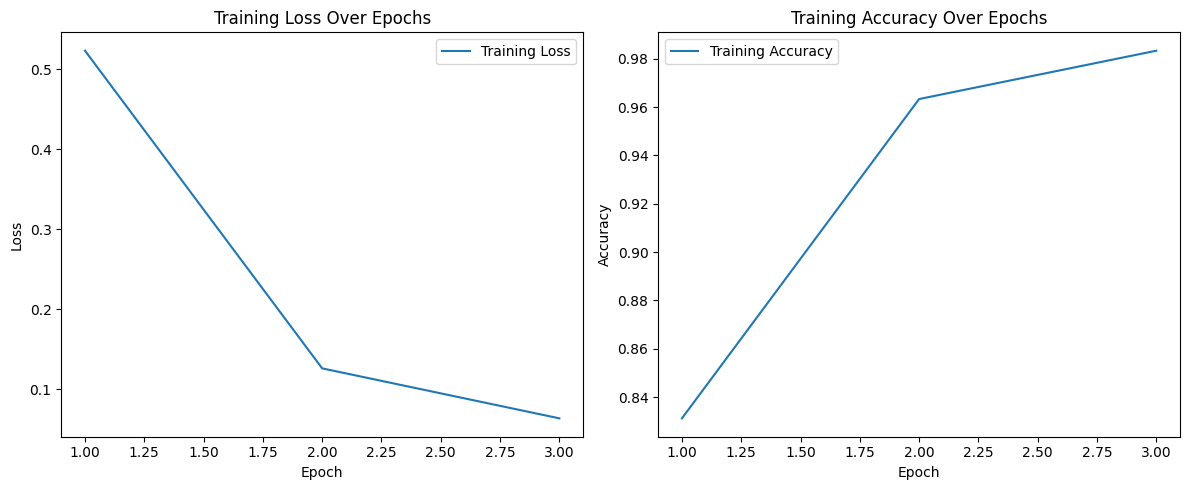

In [21]:
# Plotting accuracy and loss curves
def plot_training_curves(epochs, train_losses, train_accuracies):
    """
    Plots the training loss and accuracy curves.

    Parameters:
    - epochs: Number of epochs (int).
    - train_losses: List of loss values for each epoch.
    - train_accuracies: List of accuracy values for each epoch.
    """
    plt.figure(figsize=(12, 5))

    # Plotting the loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plotting the accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(epochs, train_losses, train_accuracies)

# **Model evaluation**

In [26]:
# Model Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9620


# **Results**

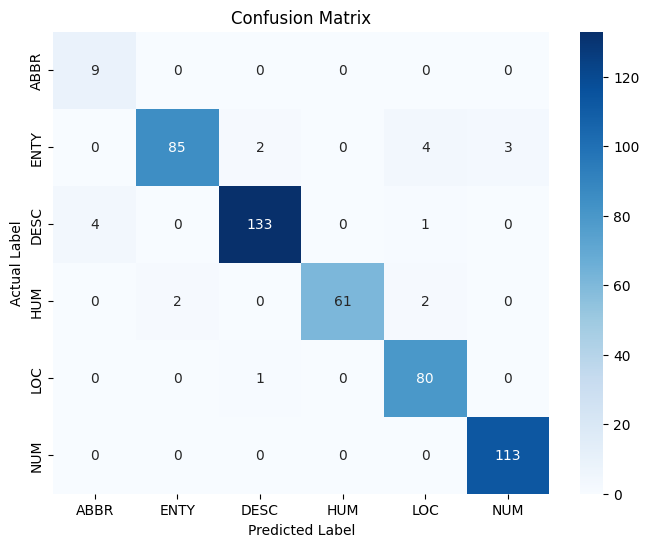

In [30]:
# Verify that label_names is a list containing the actual label names
label_names = dataset['train'].features['coarse_label'].names

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

In [31]:
# Generate the classification report
classification_report_output = classification_report(true_labels, predictions, target_names=label_names)
print("\nClassification Report:")
print(classification_report_output)


Classification Report:
              precision    recall  f1-score   support

        ABBR       0.69      1.00      0.82         9
        ENTY       0.98      0.90      0.94        94
        DESC       0.98      0.96      0.97       138
         HUM       1.00      0.94      0.97        65
         LOC       0.92      0.99      0.95        81
         NUM       0.97      1.00      0.99       113

    accuracy                           0.96       500
   macro avg       0.92      0.97      0.94       500
weighted avg       0.97      0.96      0.96       500



# **Example predictions**

In [33]:
# Select 5 random indices from the test set
def print_random_predictions(model, tokenizer, tokenized_dataset, label_names, device, num_samples=5):
    """
    Selects random samples from the test set, makes predictions using the model, and prints the results.

    Parameters:
    - model: The trained BERT model.
    - tokenizer: The tokenizer used to preprocess the text.
    - tokenized_dataset: The tokenized test dataset.
    - label_names: List of label names corresponding to label IDs.
    - device: The device to perform the computations on (e.g., 'cpu' or 'cuda').
    - num_samples: Number of random samples to select and predict (default is 5).
    """
    # Randomly choose indices from the test set
    selected_indices = random.sample(range(len(tokenized_dataset)), num_samples)

    # Set model to evaluation mode
    model.eval()

    for idx in selected_indices:
        # Get the input data
        input_ids = tokenized_dataset['input_ids'][idx].unsqueeze(0).to(device)
        attention_mask = tokenized_dataset['attention_mask'][idx].unsqueeze(0).to(device)

        # Get the true label
        true_label_id = tokenized_dataset['labels'][idx].item()
        true_label = label_names[true_label_id]

        # Make a prediction
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred_label_id = torch.argmax(outputs.logits, dim=-1).item()
            pred_label = label_names[pred_label_id]

        # Print the results
        original_text = tokenizer.decode(tokenized_dataset['input_ids'][idx], skip_special_tokens=True)
        print(f"Original Text: {original_text}")
        print(f"True Label: {true_label}")
        print(f"Predicted Label: {pred_label}\n")


print_random_predictions(model, tokenizer, tokenized_datasets['test'], label_names, device, num_samples=5)

Original Text: where are the rocky mountains?
True Label: LOC
Predicted Label: LOC

Original Text: what were christopher columbus'three ships?
True Label: ENTY
Predicted Label: ENTY

Original Text: what is maryland's state bird?
True Label: ENTY
Predicted Label: ENTY

Original Text: who was the first vice president of the u. s.?
True Label: HUM
Predicted Label: HUM

Original Text: what is the life expectancy for crickets?
True Label: NUM
Predicted Label: NUM

